In [29]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)

### Set file names
outFilePath='../data/proc/'

### Other run settings
runningLocation = 'local'
if  runningLocation== 'local':
    truthIniFilePath='../data/raw/truth/'
    pertIniFilePath='../data/raw/1week/'
elif runningLocation == 'gdata':
    truthIniFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_ObsVerification/output/'
    pertIniFilePath ='/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/'

iniPrefix = 'ini_his'

loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


### Load functions

In [30]:
### function to load overlapping OSSE data
def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    err=err2**(1/2)
    output = indexMeanMetric(err,etaRange,xiRange)
    return err,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    etaRange=range(etaRange[0],etaRange[1]+1)
    xiRange=range(xiRange[0],xiRange[1]+1)
    output = input.isel(eta_rho=etaRange, xi_rho=xiRange).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMap(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa 

In [59]:
### Load truth ini file data

truthIniPath = truthIniFilePath+iniPrefix+'.nc'

truthIni = xr.open_dataset(truthIniPath)
truthZeta = truthIni.zeta.isel(ocean_time=0).load()

In [58]:
### Load perturbed ini file data

pertIniPath = pertIniFilePath+iniPrefix+'.nc'

pertIni = xr.open_dataset(pertIniPath)
pertZeta = pertIni.zeta.isel(ocean_time=0).load()

In [60]:
diffTruthPertZeta = truthZeta - pertZeta

In [61]:
diffTruthPertZeta

<xarray.DataArray 'zeta' (eta_rho: 317, xi_rho: 272)>
array([[       nan,        nan,        nan, ..., 0.0679263 , 0.06531137,
        0.0653113 ],
       [       nan,        nan,        nan, ..., 0.06792605, 0.06531136,
        0.06531122],
       [       nan,        nan,        nan, ..., 0.06609787, 0.06385538,
        0.06385541],
       ...,
       [       nan,        nan,        nan, ..., 0.031201  , 0.032444  ,
        0.03246346],
       [       nan,        nan,        nan, ..., 0.03055185, 0.03193647,
        0.0319511 ],
       [       nan,        nan,        nan, ..., 0.03055367, 0.03194821,
        0.03194967]], dtype=float32)
Coordinates:
    lon_rho  (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.1 162.2 162.2
    lat_rho  (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
Dimensions without coordinates: eta_rho, xi_rho

Text(0.5, 1.0, 'Truth - Perturbation. Contours @ 0.25m')

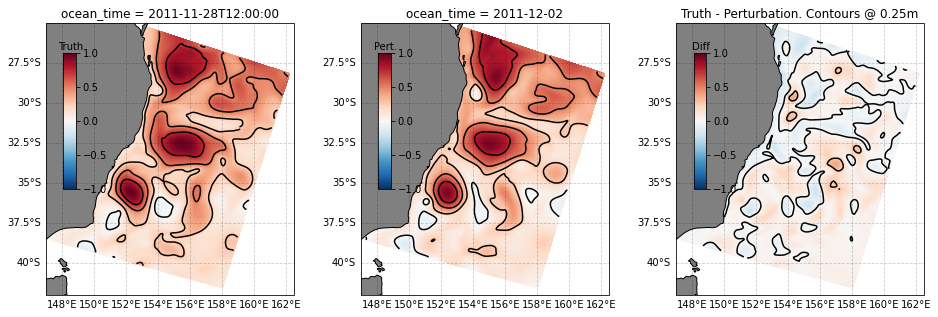

In [100]:

fig = plt.figure(figsize=(16,5))
iSz,jSz = (1,3)
gs = fig.add_gridspec(iSz, jSz)


ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = truthZeta.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False)       
co = truthZeta.plot.contour('lon_rho','lat_rho',levels=np.arange(-1, 1, 0.25), ax=ax, colors='k')
im.set_clim([-1,1])
ax.text(.1,.9,'Truth',horizontalalignment='center',transform=ax.transAxes)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
fig.colorbar(im, cax=cax)

ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = pertZeta.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False)       
co = pertZeta.plot.contour('lon_rho','lat_rho',levels=np.arange(-1, 1, 0.25), ax=ax, colors='k')
im.set_clim([-1,1])
ax.text(.1,.9,'Pert.',horizontalalignment='center',transform=ax.transAxes)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  
                height="50%",  
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
fig.colorbar(im, cax=cax)

ax = fig.add_subplot(gs[2], projection=ccrs.PlateCarree())
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = diffTruthPertZeta.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False)       
co = diffTruthPertZeta.plot.contour('lon_rho','lat_rho',levels=np.arange(-1, 1, 0.25), ax=ax, colors='k')
im.set_clim([-1,1])
ax.text(.1,.9,'Diff',horizontalalignment='center',transform=ax.transAxes)
# plt.tight_layout()
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
fig.colorbar(im, cax=cax)
ax.set_title('Truth - Perturbation. Contours @ 0.25m')
